# Unmasking the Web of Deceit: An Analysis of Online Payment Fraud
## Data Mining 412/512 Team 4 Project Report

### Instructor
* Dr. Maninder Singh

### Authors
* Shawn Eidem - shawn.eidem@go.stcloudstate.edu
* William Ortman - william.ortman@go.stcloudstate.edu
* Noah Blon - noah.blon@go.stcloudstate.edu
* Ashhad Waquad Syed - ashhadwaquas.syed@go.stcloudstate.edu

## Overview
### Background
E-commerce has exploded globally, fueled by a pandemic and the widespread use of mobile phones. In 2023, online transactions are expected to account for nearly 21% of all financial activities in 2023, totaling over 8 trillion dollars [1]. Unfortunately, with this growth has come a huge increase in fraud. In 2022, global losses due to fraud reached 41 billion dollars, and will jump over 48 billion dollars in 2023. By 2027, losses are projected to exceed 343 billion [2].

Because the problem is widespread, damaging, and on-the-rise, it is vital to prevent businesses and individuals from becoming victims of fraud. But with such a huge number of transactions, it’s impossible to find fraudulent ones manually. Data mining techniques such as machine learning, are able to sift through huge datasets and find actionable intelligence, making them critical tools to combat the problem.

### Research Questions
**What are the most accurate machine learning algorithms for binary classification?**

We’ll test Naive Bayes, SVM, and Decision Trees algorithms and evaluate them using common metrics to find which score best.

**Which algorithms are the most resilient to class imbalance?**

We will test Naive Bayes, SVM, and Decision Trees with the original dataset and a sampled dataset to see if there are any differences in performance.

### Algorithm Description

#### Naive Bayes
Naive Bayes is a simple yet effective classification algorithm based on Bayes' theorem. It assumes that features are conditionally independent, given the class label. It is simple and fast, but assuming conditional independence is a downside. [3]

#### SVM
SVM is a supervised learning algorithm that can be used for classification problems. The primary objective is to find a hyperplane that best separates data points of different classes in the feature space. SVM aims to maximize the margin between classes, making it robust to outliers. [4]

### Decision Trees
Decision Trees is a supervised machine learning algorithm that can be used for classification problems. It has a hierarchical tree structure consisting of a root node, branches, internal nodes, and leaf nodes. Each node represents the predicted class. [5]


### Dataset Description
The dataset we will explore is the “Online Payments Fraud Detection” Dataset located on Kaggle [6]. Some features which contributed to our selection of the dataset were:
* The dataset features mostly numeric attributes, negating a need for transformations.
* We believe there are few or zero missing feature values.
* It's substantial, containing over 6 million rows of data. This makes it similar to a real world problem.
* The dataset presents a binary classification problem, which simplifies our analysis.

Due to privacy reasons, there is a lack of publicly available datasets on mobile money transactions. Therefore, this data was generated through a tool called PaySim, and its features were found comparable to real-world financial data. We are using a subset of the original dataset which included 23 million rows [7].

The description of the columns are as follows:

* step: represents a unit of time, where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction flag
* isFlaggedFraud: fraud transaction flag for transactions over $200,000

The use of a simulated dataset is due to government restrictions preventing access to real-world bank transaction information. PaySim’s synthetic dataset is based on real-world transaction information and is tailored towards the use of machine learning.[6] This dataset is uniquely suited for training as the data is nearly fully complete and considered by many to be a clean data set, with the addition of a column dedicated for isFraud for pre-classified data for easy training purposes. This data is considered highly accurate to real world occurrences and as such is a great match for our project's goals.

### Hardware Overview

* RAM (Random Access Memory): 32GB
* Processor: Apple M1 Pro
* Operating System: Mac OS Sonoma
* Storage: 500GBs

This notebook has been run successfully on this hardware and takes a reasonable time to complete.

### Evaluation Plan
As a general part of evaluating the project, we compare our trained models and their predictions against the actual data for our selected algorithms. This providse a measure of accuracy and allow us to understand how the models perform. The training, testing, and validation will be done using an 80%/10%/10% split of the data respectively. The metrics collected from testing/training will be the F1 score, precision, and accuracy. We also run our training against a preprocessed, sampled dataset and the original dataset to understand how preprocessing, especially class balancing, effects the performance of our selected classification algorithms.

## Setup

### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import os.path
import zipfile
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
import time


### Import Dataset
This downloads the dataset from Kaggle and reads it into a Pandas DataFrame. See README for instructions on how to set up a Kaggle API key.  Otherwise, download the file and put it in the `/data` folder with the name `online-payments-fraud-detection-dataset.csv`.

In [2]:
# Authenticate with your Kaggle credentials
api = KaggleApi()
api.authenticate()

# Specify the dataset name
dataset_name = 'online-payments-fraud-detection-dataset'
dataset_folder_path = './data/'
kaggle_dataset_path = 'rupakroy/' + dataset_name

if os.path.isfile(dataset_folder_path + dataset_name + '.csv'):
    print("Found dataset archive.")
else:
    # Download the dataset files
    print("Downloading dataset from Kaggle.")
    api.dataset_download_files(kaggle_dataset_path, path=dataset_folder_path)

    zip_file_path = dataset_folder_path + dataset_name + '.zip'

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(dataset_folder_path)

    # Delete the zip file
    os.remove(zip_file_path)
    for filename in zip_ref.namelist():
        new_filename = dataset_name + '.csv'
        old_filepath = os.path.join(dataset_folder_path, filename)
        new_filepath = os.path.join(dataset_folder_path, new_filename)
        os.rename(old_filepath, new_filepath)
    print("Downloaded dataset from Kaggle.")

df = pd.read_csv(dataset_folder_path + dataset_name + '.csv')
# make a copy to preserve the original data
dff = df.copy()

Found dataset archive.


In [3]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Dataset Exploration and Preprocessing

To set up our analysis for success, we need to analyze, reduce, and manipulate our dataset to achieve the best classification results. First, we’ll inspect and sanitize the data to make sure values are not missing and have the correct type. Our dataset is generated and we expect it to be very clean, but we’ll take this step to mimic actions we’d take on a real-world dataset. Next, we’ll test the data for attributes such as skewness and outliers, and reduce the data where necessary.  Finally, we’ll test for whether our class feature, isFraud, is imbalanced.  If so, we’ll look at techniques such as sampling to ensure we have balanced testing and training data. We may undertake analysis of our algorithms using sampled and unsampled data to test their resistance to imbalanced data.

### Check for empty data

In [4]:
if dff.isnull().values.any():
    print("Error: Missing data")
else:
    print("No missing values found.")

No missing values found.


### Rename Columns

We rename the columns to be easier to understand, based on descriptions of the dataset.

In [5]:
print(f'Before: {dff.columns}')

dff.columns = ['Transaction_Hours','Type','Transaction_Amount','Sender','Sender_Balance_Before_Transaction','Sender_Balance_After_Transaction','Receiver','Receiver_Balance_Before_Transaction','Receiver_Balance_After_Transaction','Is_Fraud', 'Is_Flagged_Fraud']

print(f'After: {dff.columns}')


Before: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
After: Index(['Transaction_Hours', 'Type', 'Transaction_Amount', 'Sender',
       'Sender_Balance_Before_Transaction', 'Sender_Balance_After_Transaction',
       'Receiver', 'Receiver_Balance_Before_Transaction',
       'Receiver_Balance_After_Transaction', 'Is_Fraud', 'Is_Flagged_Fraud'],
      dtype='object')


### Drop irrelevant columns

We drop columns that aren't needed for analysis:
* Sender - the ID of the initiator of the transaction
* Receiver - the ID of the receiver of the transaction
* Is_Flagged_Fraud - a classification field containing an extremely low number of positives

In [6]:
print(dff['Is_Flagged_Fraud'].value_counts())

print(f'Before: {dff.columns}')

dff = dff.drop('Sender', axis=1)
dff = dff.drop('Receiver', axis=1)
dff = dff.drop('Is_Flagged_Fraud', axis=1)

print(f'After: {dff.columns}')


Is_Flagged_Fraud
0    6362604
1         16
Name: count, dtype: int64
Before: Index(['Transaction_Hours', 'Type', 'Transaction_Amount', 'Sender',
       'Sender_Balance_Before_Transaction', 'Sender_Balance_After_Transaction',
       'Receiver', 'Receiver_Balance_Before_Transaction',
       'Receiver_Balance_After_Transaction', 'Is_Fraud', 'Is_Flagged_Fraud'],
      dtype='object')
After: Index(['Transaction_Hours', 'Type', 'Transaction_Amount',
       'Sender_Balance_Before_Transaction', 'Sender_Balance_After_Transaction',
       'Receiver_Balance_Before_Transaction',
       'Receiver_Balance_After_Transaction', 'Is_Fraud'],
      dtype='object')


### Check for correct data types
We look at type for each column and find that the data types look appropriate. We also explore the Type column to find nominal data which we will convert later. We explore Is_Fraud and find it to correctly be values 0, meaning not fraudulent, and 1, meaning fraudulent. We will convert this to a boolean later for ease of use.

In [7]:
# Print datatypes of features to ensure they are the correct type
dff.info()
print('\n Type Value Counts: \n\n')
print(dff['Type'].value_counts())
print('\n Fraud Value Counts: \n\n')
print(dff['Is_Fraud'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Transaction_Hours                    int64  
 1   Type                                 object 
 2   Transaction_Amount                   float64
 3   Sender_Balance_Before_Transaction    float64
 4   Sender_Balance_After_Transaction     float64
 5   Receiver_Balance_Before_Transaction  float64
 6   Receiver_Balance_After_Transaction   float64
 7   Is_Fraud                             int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB

 Type Value Counts: 


Type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

 Fraud Value Counts: 


Is_Fraud
0    6354407
1       8213
Name: count, dtype: int64


### Convert Nominal Features to Boolean
We convert the Type category to columns using one-hot encoding. This creates a new binary column for each category and is a better choice for nominal variables where there is no intrinsic order. [8]

In [8]:

# Assuming 'df' is your DataFrame
categorical_columns = dff.select_dtypes(include=['object', 'category']).columns

# One-hot encoding: This creates a new binary column for each category and is appropriate for nominal variables without an intrinsic order.
dff = pd.get_dummies(dff, columns=categorical_columns)

dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Transaction_Hours                    int64  
 1   Transaction_Amount                   float64
 2   Sender_Balance_Before_Transaction    float64
 3   Sender_Balance_After_Transaction     float64
 4   Receiver_Balance_Before_Transaction  float64
 5   Receiver_Balance_After_Transaction   float64
 6   Is_Fraud                             int64  
 7   Type_CASH_IN                         bool   
 8   Type_CASH_OUT                        bool   
 9   Type_DEBIT                           bool   
 10  Type_PAYMENT                         bool   
 11  Type_TRANSFER                        bool   
dtypes: bool(5), float64(5), int64(2)
memory usage: 370.1 MB


### Update Is_Fraud to Boolean type

In [9]:
# Assuming 'dff' is your DataFrame and 'isFraud' is a column with int64 type containing 0s and 1s
dff['Is_Fraud'] = dff['Is_Fraud'].astype(bool)
# Check the updated data type
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Transaction_Hours                    int64  
 1   Transaction_Amount                   float64
 2   Sender_Balance_Before_Transaction    float64
 3   Sender_Balance_After_Transaction     float64
 4   Receiver_Balance_Before_Transaction  float64
 5   Receiver_Balance_After_Transaction   float64
 6   Is_Fraud                             bool   
 7   Type_CASH_IN                         bool   
 8   Type_CASH_OUT                        bool   
 9   Type_DEBIT                           bool   
 10  Type_PAYMENT                         bool   
 11  Type_TRANSFER                        bool   
dtypes: bool(6), float64(5), int64(1)
memory usage: 327.7 MB


### Check for skewed distributions

We explore the numeric data for skewed distributions and Transaction_Amount, Sender_Balance_Before_Transaction, Sender_Balance_After_Transaction, Receiver_Balance_Before_Transaction, Receiver_Balance_After_Transaction are skewed right. We'll employ methods to correct the skewness for better results of our classification model.

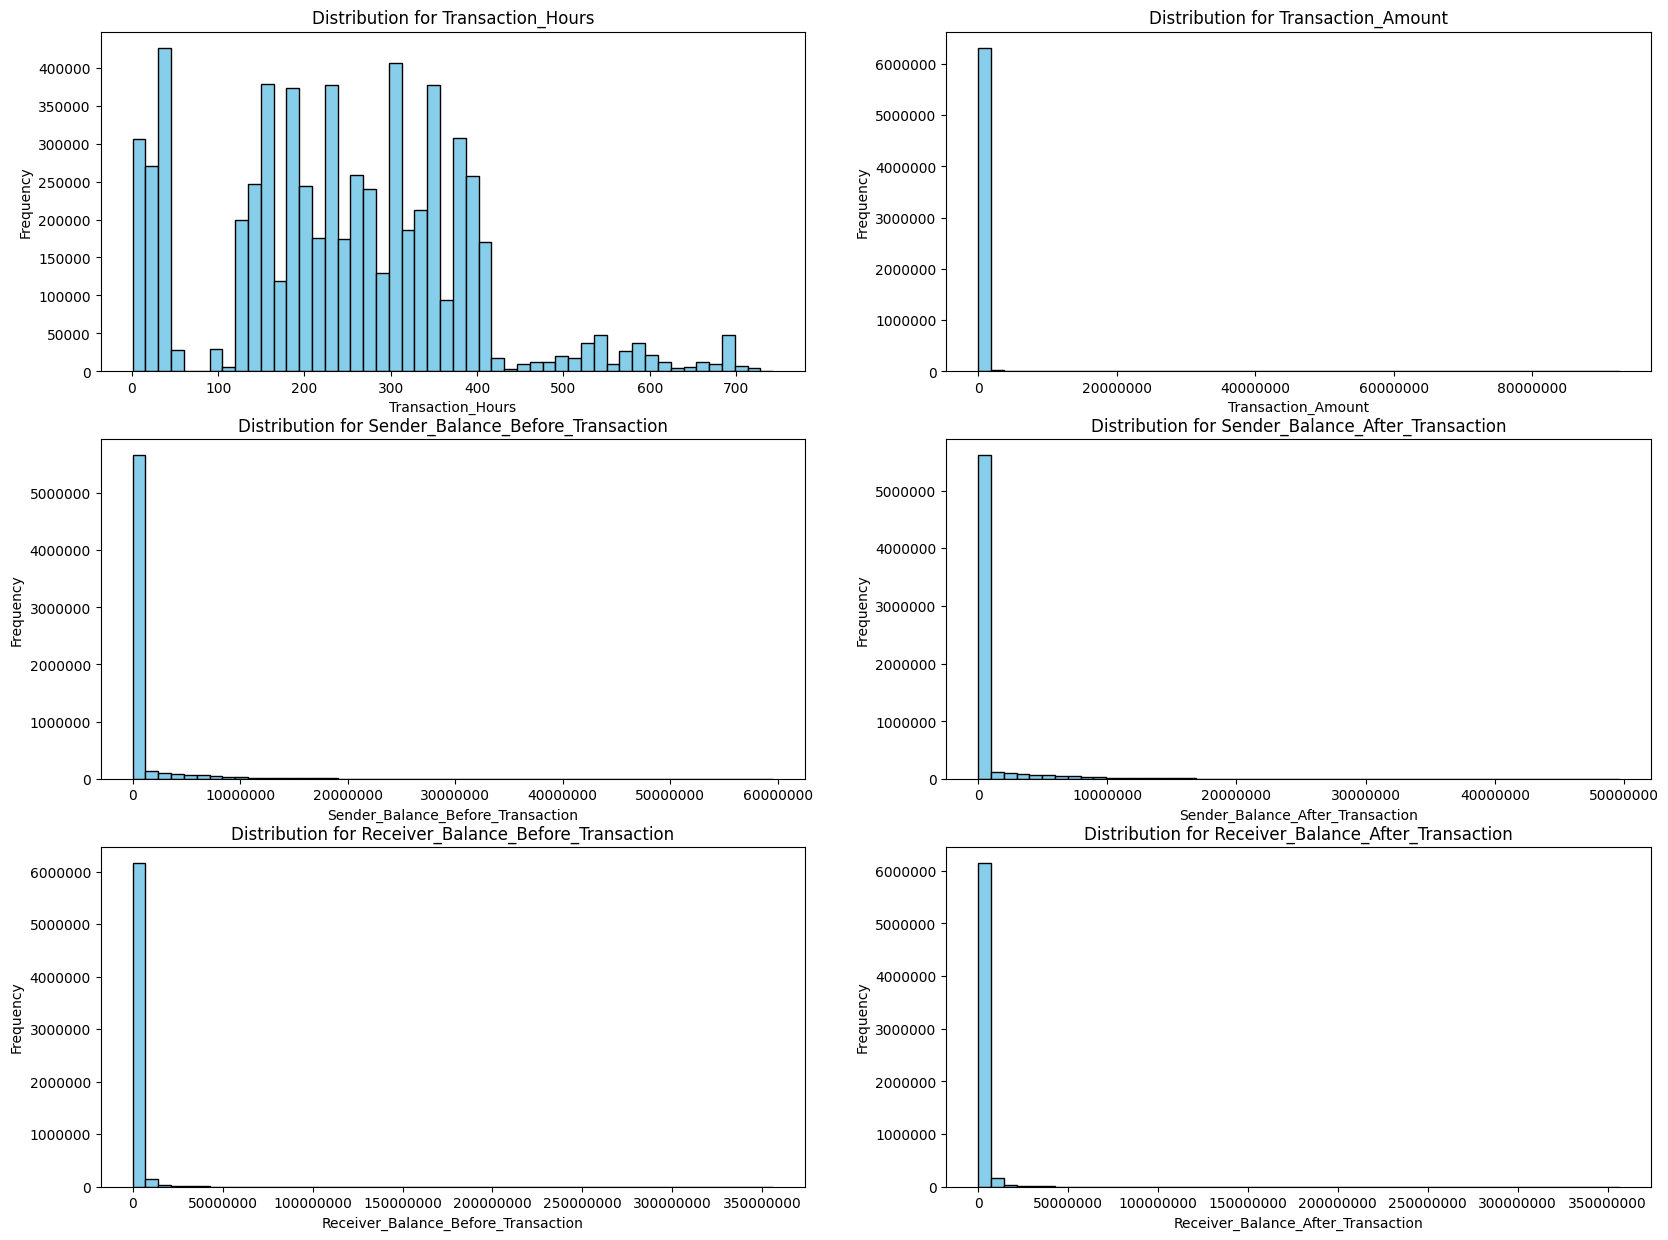

In [10]:
plt.figure(figsize=(20,15))

numerical_features = dff.select_dtypes(include=['int64', 'float64']).columns

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    plt.hist(dff[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

plt.show()

### Remove outliers

To remove the outliers, we'll use the IQR range and preserve data within the middle 50% of data points. To calculate the quartiles, we look at the range of the positive fraud data rather than the entire dataset, which should lead to better classification results. Interestingly, using this method, we find that the Sender_Balance_After_Transaction is mostly around 0 for Is_Fraud transactions. This makes sense, as accounts with higher balances are likely not engaging in fraud.

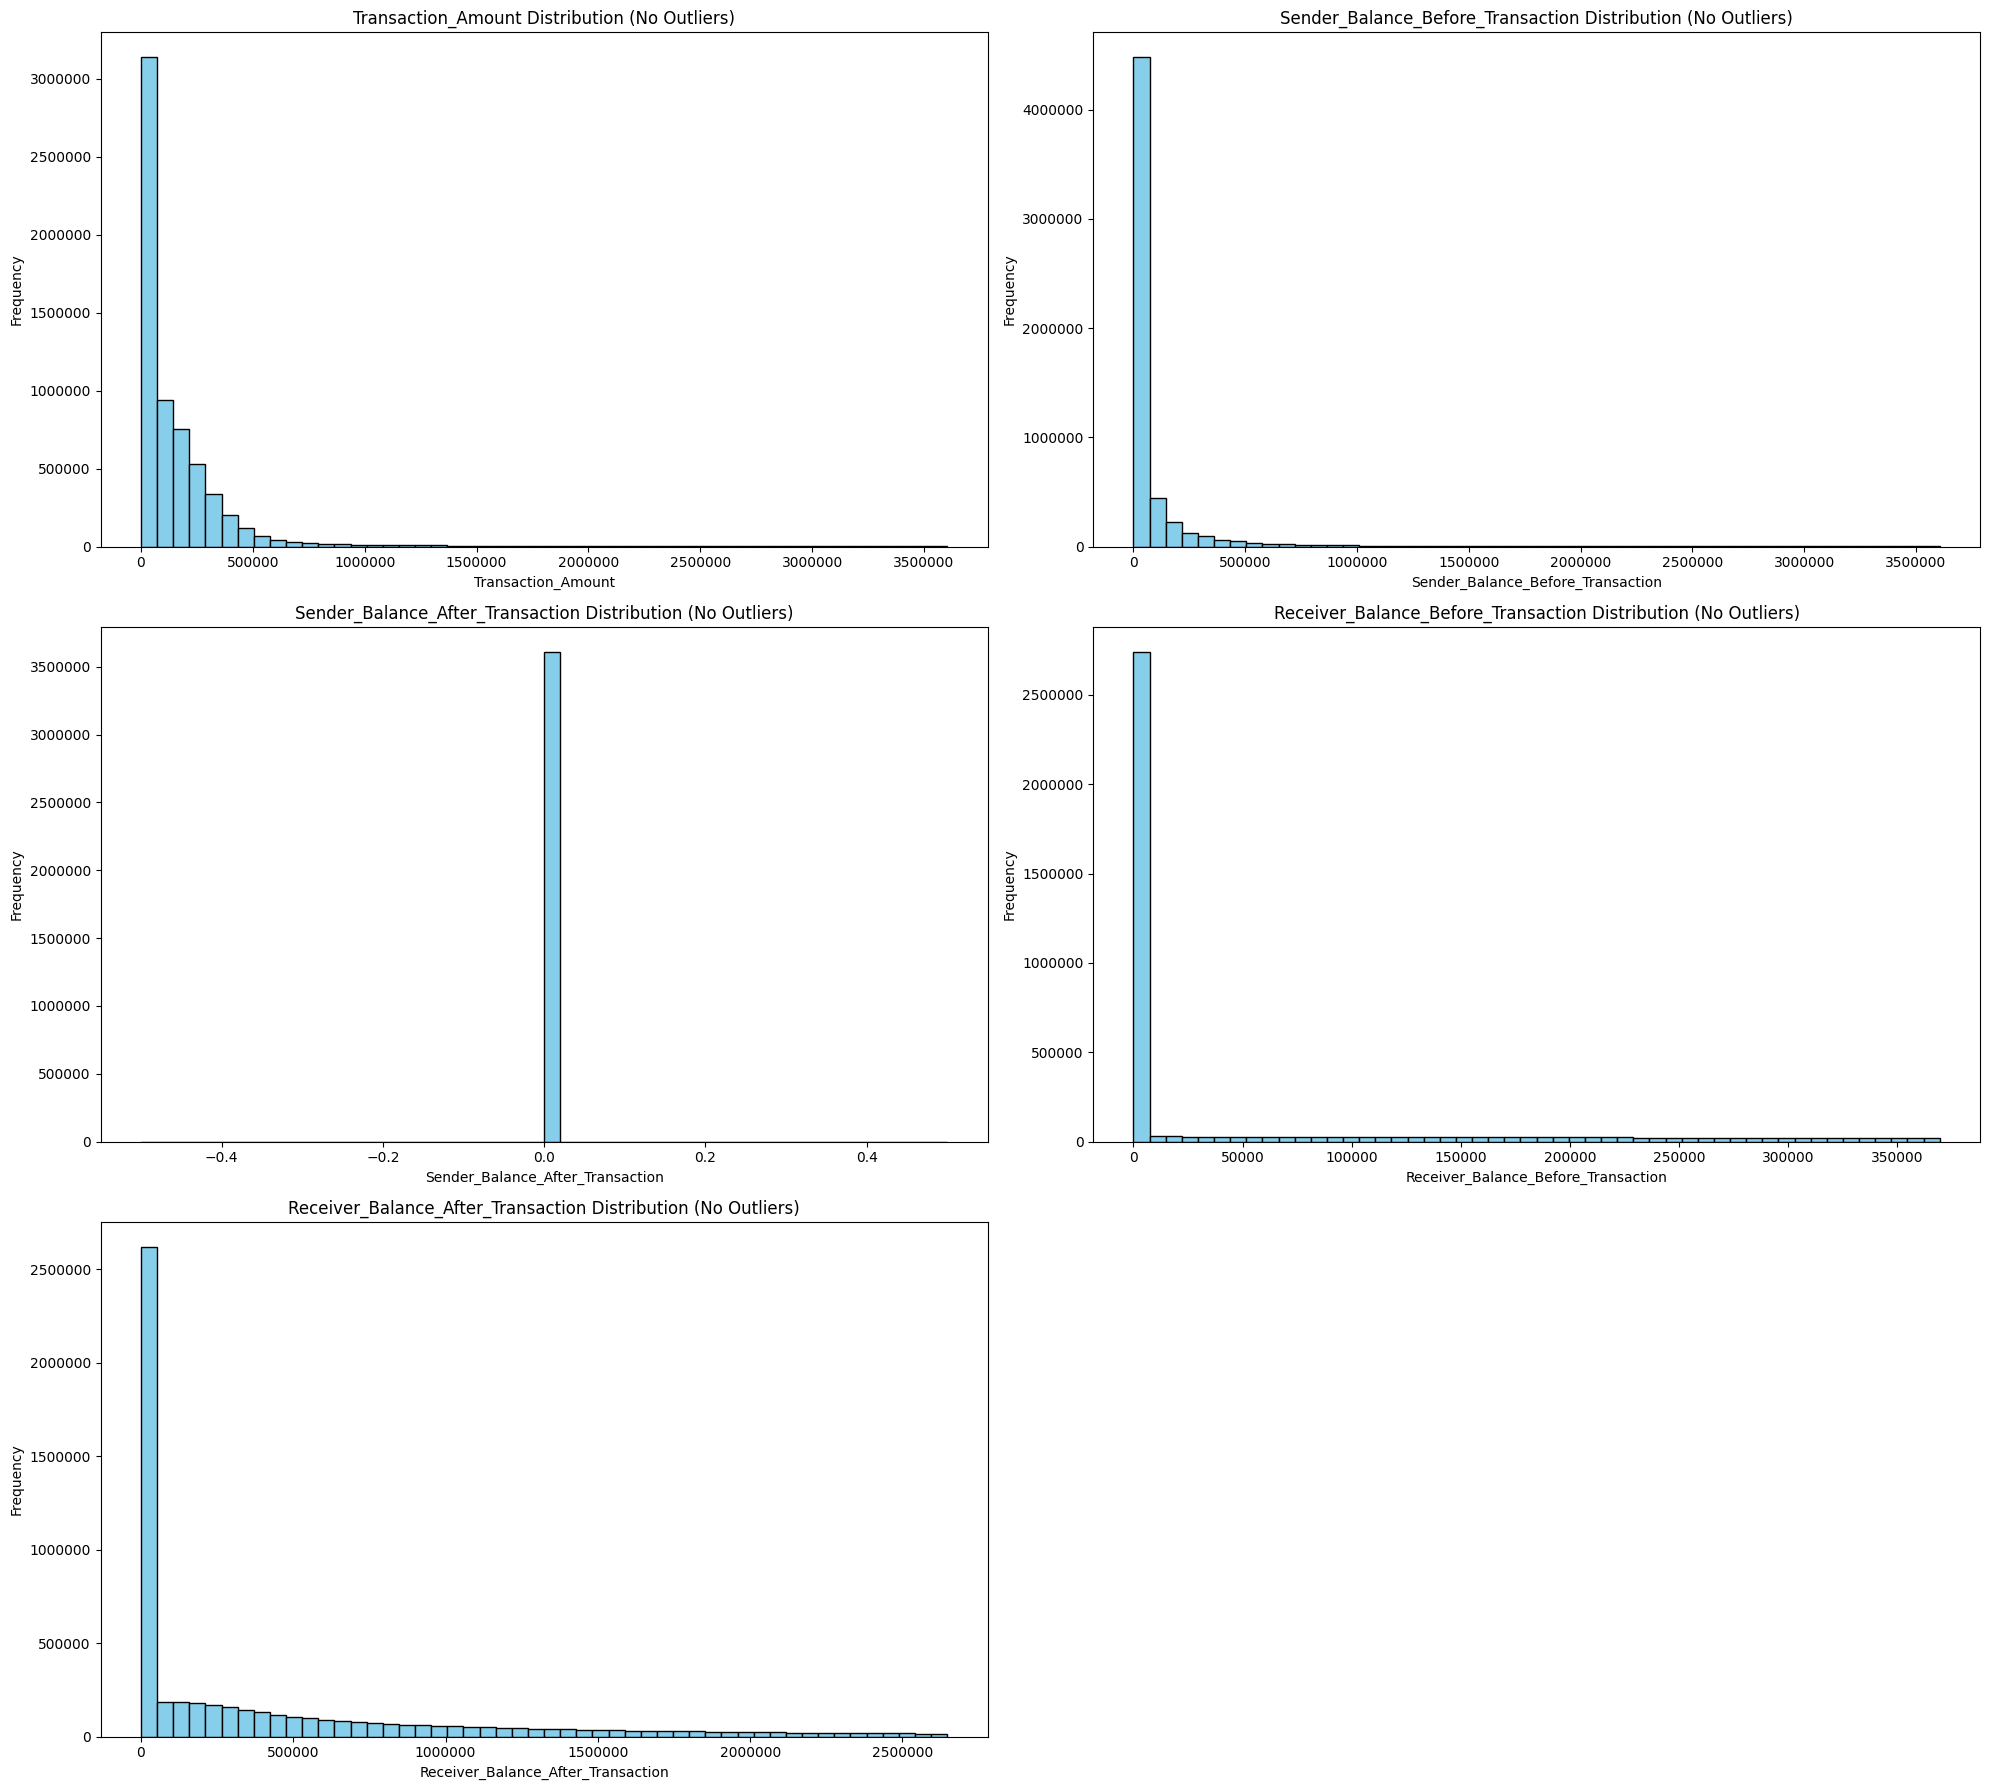

In [11]:
plt.figure(figsize=(20,18))

skewed_features = numerical_features.drop('Transaction_Hours')

positive_fraud_data = dff[dff['Is_Fraud'] == 1]

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(skewed_features, 1):
    # Calculate the IQR
    Q1 = positive_fraud_data[feature].quantile(0.25)
    Q3 = positive_fraud_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and filter out outliers
    df_no_outliers = dff[(dff[feature] >= lower_bound) & (dff[feature] <= upper_bound)]

    # Plot histogram of Transaction Amount after removing outliers
    plt.subplot(3, 2, i)
    plt.hist(df_no_outliers[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{feature} Distribution (No Outliers)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


### Check for Class Imbalance

We now check for class imbalance, where the main class, in this case Is_Fraud, is rare. Checking the count of values, we see that the in fact our class is highly imbalanced and correcting the class imbalance should help our classification models.

We can employ sampling, where we change the training data distribution so that the Is_Fraud is well represented. Undersampling decreases the number of negative tuples to align with the positive ones. Oversampling creates new positive tuples to that there are an equal number of positive and negatives. [9]

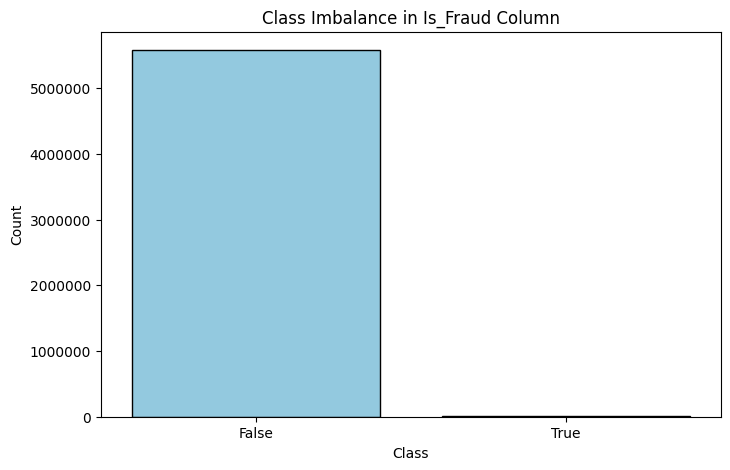

In [12]:
target = df_no_outliers['Is_Fraud']

plt.figure(figsize=(8, 5))

# Plot the class imbalance
sns.countplot(x=target, hue=target, palette=["skyblue", "coral"], legend=False, edgecolor='black')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance in Is_Fraud Column')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

### Undersample data
First we reduce the number of negative sample to match the number of positive ones by undersampling.

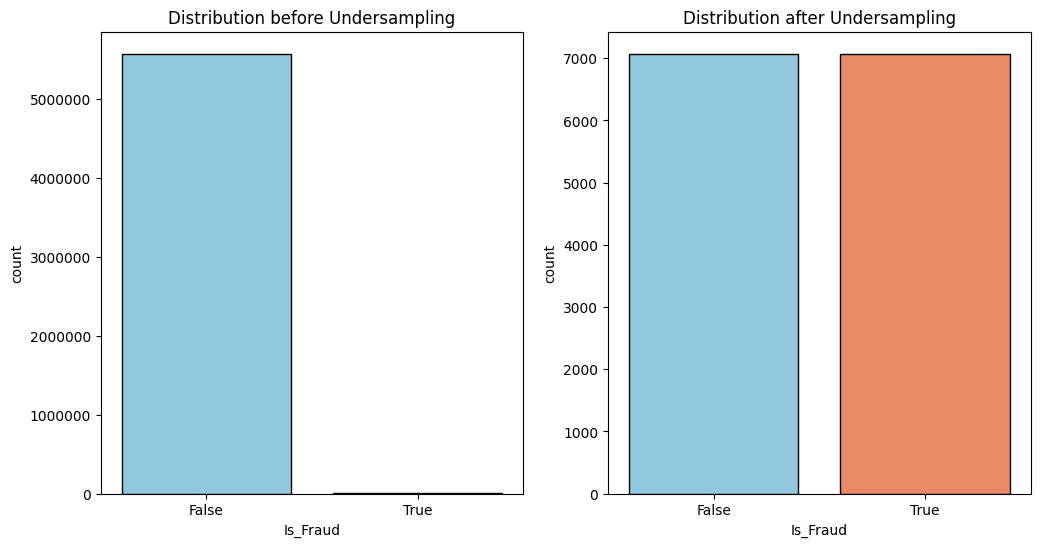

In [13]:
# Perform undersampling on the majority class
features = df_no_outliers.drop('Is_Fraud', axis=1)
target = df_no_outliers['Is_Fraud']

# The majority class is typically the class with more instances in an imbalanced dataset. 
# Undersampling aims to balance the class distribution by reducing the number of instances in the majority class.
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
features_undersampled, target_undersampled = undersampler.fit_resample(features, target)

# Plot the distribution before and after undersampling
plt.figure(figsize=(12, 6))

# Plot the distribution before undersampling
plt.subplot(1, 2, 1)
sns.countplot(x=target, hue=target, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution before Undersampling')
plt.ticklabel_format(style='plain', axis='y')

# Plot the distribution after undersampling
plt.subplot(1, 2, 2)
sns.countplot(x=target_undersampled, hue=target_undersampled, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution after Undersampling')

plt.show()


### Oversample the data
Having achieved class balance, we use SMOTE - Synthetic Minority Sampling Technique - to boost the sample count to 100,000, a threshold where our classification models should perform better. [10]

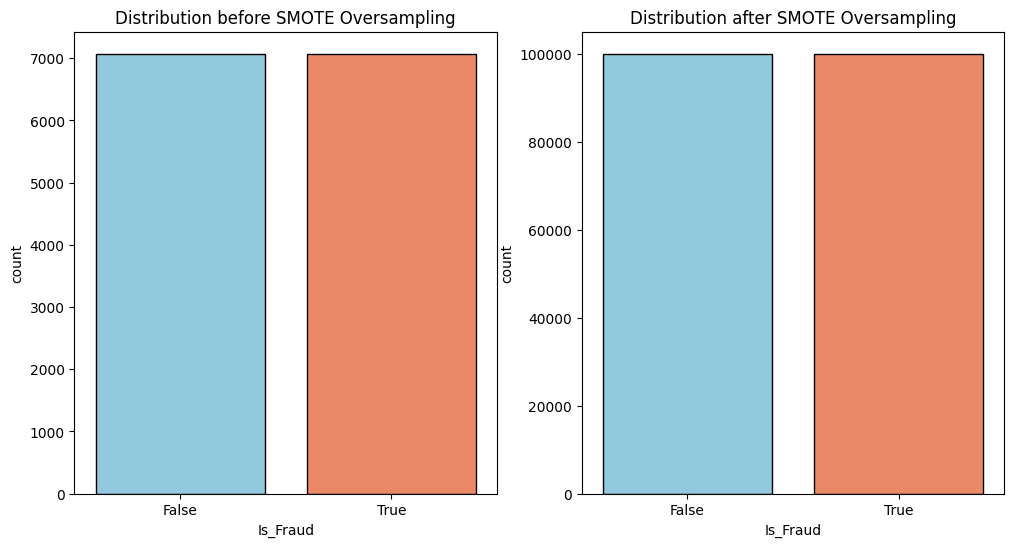

In [14]:
# Set the desired samples for each class to 100,000
desired_samples = 100000

# Keys represent class labels, and values represent the desired number of samples for each class after oversampling.
sampling_strategy = {0: desired_samples, 1: desired_samples}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
features_oversampled_smote, target_oversampled_smote = smote.fit_resample(features_undersampled, target_undersampled)

# Plot the distribution before and after SMOTE oversampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=target_undersampled, hue=target_undersampled, palette=["skyblue", "coral"], legend=False, edgecolor='black')

plt.title('Distribution before SMOTE Oversampling')

plt.subplot(1, 2, 2)
sns.countplot(x=target_oversampled_smote,  hue=target_oversampled_smote, palette=["skyblue", "coral"], legend=False, edgecolor='black')
plt.title('Distribution after SMOTE Oversampling')

plt.show()


## Classification
Now that we have completed classification, we can begin training and testign against our three algorithms, Naive Bayes, SVM, and Decision Trees. 
### Split Data
First we must split the data between our training, testing, and validation sets. We keep an even distribution of our positive and negative class labels between these sets.

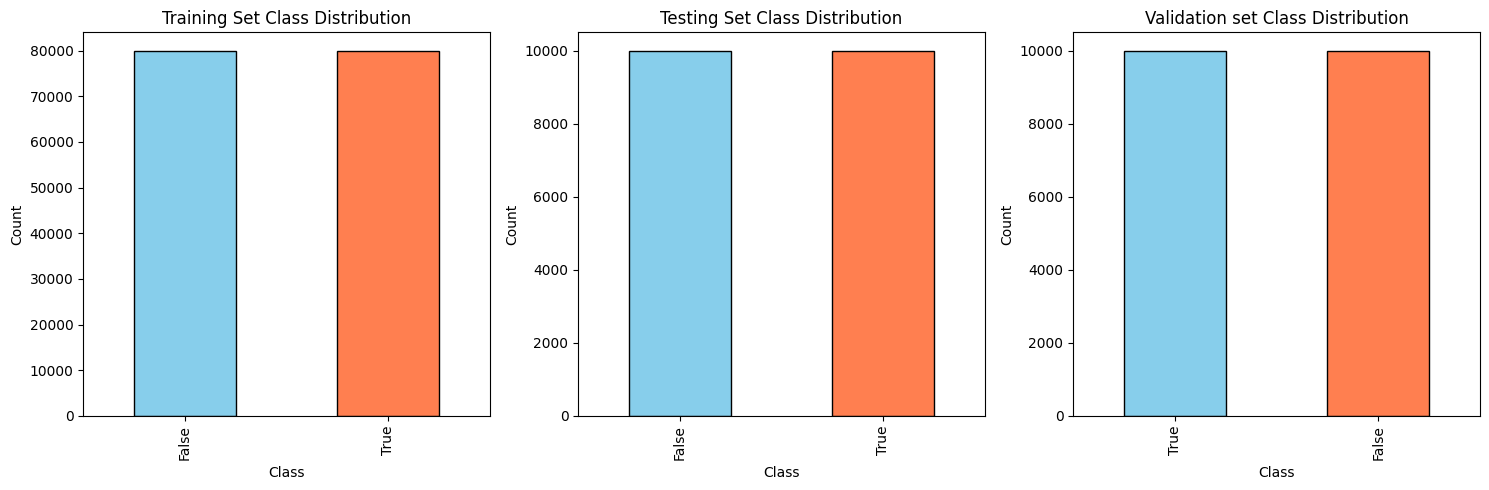

In [15]:
# Split the resampled data into training, validation, and two testing sets (80/10/10 split)
# The stratify parameter ensures that the splitting of the dataset maintains the same distribution of target classes as the original dataset.
X_train, X_temp, y_train, y_temp = train_test_split(features_oversampled_smote, target_oversampled_smote, test_size=0.2, random_state=42, stratify=target_oversampled_smote)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Plot the class distribution of all three sets
plt.figure(figsize=(15, 5))

# Training Set Class Distribution
plt.subplot(1, 3, 1)
# Series converts a one-dimensional array or list into a pandas Series, which is a labeled one-dimensional array.
pd.Series(y_train).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Testing Set Class Distribution
plt.subplot(1, 3, 2)
pd.Series(y_test).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Testing Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Validation Set Class Distribution
plt.subplot(1, 3, 3)
pd.Series(y_val).value_counts().plot(kind='bar', color=['skyblue', 'coral'], edgecolor='black')
plt.title('Validation set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Naive Bayes Classifier

Now we run train and test the Naive Bayes algorithm with our sampled data. We generate a confusion matrix and accuracy, precision, and recall metrics in order to evaluate performance.


Naive Bayes - Validation Set Results:
Accuracy: 0.74
0 minutes and 0.05 seconds


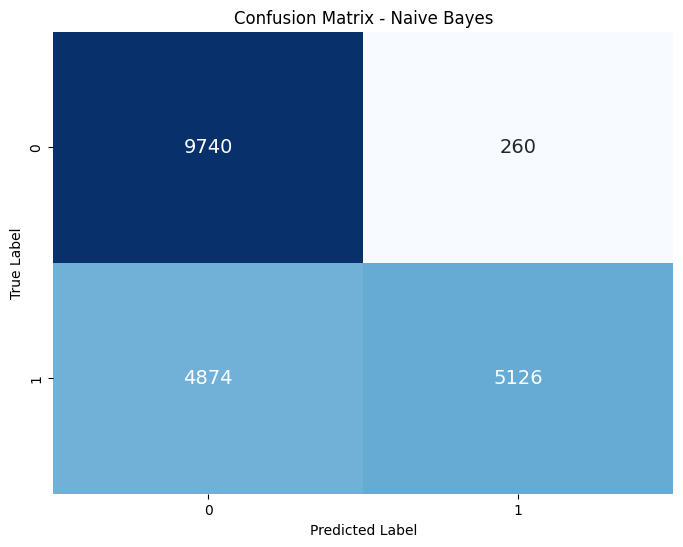

Classification Report:
              precision    recall  f1-score   support

       False      0.666     0.974     0.791     10000
        True      0.952     0.513     0.666     10000

    accuracy                          0.743     20000
   macro avg      0.809     0.743     0.729     20000
weighted avg      0.809     0.743     0.729     20000



In [16]:
# Create and train the Naive Bayes model
nb_model = GaussianNB()
start_time = time.time()
nb_model.fit(X_train, y_train)

# Make predictions on the validation set for Naive Bayes
y_val_pred_nb = nb_model.predict(X_val)

# Evaluate the Naive Bayes model on the validation set
accuracy_val_nb = accuracy_score(y_val, y_val_pred_nb)
conf_matrix_val_nb = confusion_matrix(y_val, y_val_pred_nb)
class_report_val_nb = classification_report(y_val, y_val_pred_nb, digits=3)

# Record the run time
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)

print("\nNaive Bayes - Validation Set Results:")
print(f"Accuracy: {accuracy_val_nb:.2f}")
print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

# Print a prettier confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_nb, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(class_report_val_nb)

nb_time = elapsed_time

### Decision Trees Classifier

Now we run train and test the Decision Trees algorithm with our sampled data. We generate a confusion matrix and accuracy, precision, and recall metrics in order to evaluate performance.


Decision Trees - Validation Set Results:
Accuracy: 1.00
0 minutes and 0.46 seconds


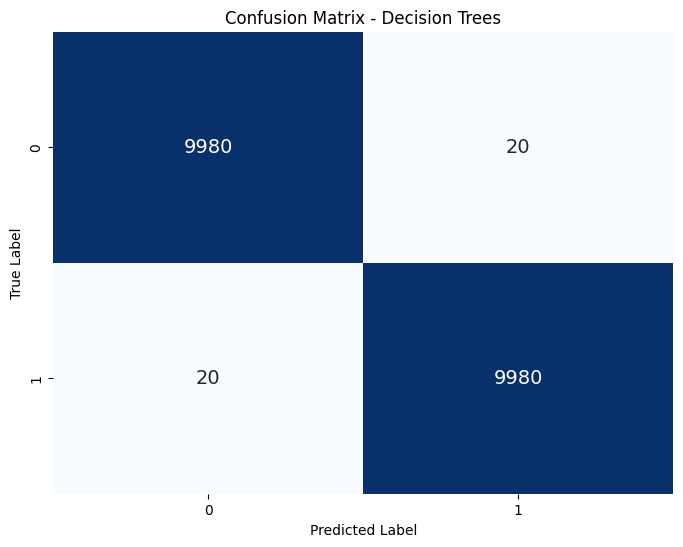

Classification Report:
              precision    recall  f1-score   support

       False      0.998     0.998     0.998     10000
        True      0.998     0.998     0.998     10000

    accuracy                          0.998     20000
   macro avg      0.998     0.998     0.998     20000
weighted avg      0.998     0.998     0.998     20000



In [17]:
# Create and train the Decision Trees model
dt_model = DecisionTreeClassifier()
start_time = time.time()
dt_model.fit(X_train, y_train)

# Make predictions on the validation set for Decision Trees
y_val_pred_dt = dt_model.predict(X_val)

# Evaluate the Decision Trees model on the validation set
accuracy_val_dt = accuracy_score(y_val, y_val_pred_dt)
conf_matrix_val_dt = confusion_matrix(y_val, y_val_pred_dt)
class_report_val_dt = classification_report(y_val, y_val_pred_dt, digits=3)

# Record the run time
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)

print("\nDecision Trees - Validation Set Results:")
print(f"Accuracy: {accuracy_val_dt:.2f}")
print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

# Print a prettier confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_dt, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix - Decision Trees")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(class_report_val_dt)

dt_time = elapsed_time


### Support Vector Machine Classifier
Now we run train and test the Support Vector Machine algorithm with our sampled data. We generate a confusion matrix and accuracy, precision, and recall metrics in order to evaluate performance.

In [18]:
# Create and train the SVM model
svm_model = SVC()
start_time = time.time()
svm_model.fit(X_train, y_train)

# Make predictions on the validation set for SVM
y_val_pred_svm = svm_model.predict(X_val)

In [ ]:
# Evaluate the SVM model on the validation set
accuracy_val_svm = accuracy_score(y_val, y_val_pred_svm)
conf_matrix_val_svm = confusion_matrix(y_val, y_val_pred_svm)
class_report_val_svm = classification_report(y_val, y_val_pred_svm, digits=3)

# Record the run time
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)

print("\nSVM - Validation Set Results:")
print(f"Accuracy: {accuracy_val_svm:.2f}")
print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

# Print a prettier confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_svm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(class_report_val_svm)

svm_time = elapsed_time


### Test the models on the test set

In [ ]:
# Test the models on the test set
y_test_pred_nb = nb_model.predict(X_test)
y_test_pred_svm = svm_model.predict(X_test)
y_test_pred_dt = dt_model.predict(X_test)

print("Naive Bayes - Test Set Results:")
print(classification_report(y_val, y_test_pred_nb));

print("SVM - Test Set Results:")
print(classification_report(y_val, y_test_pred_svm));

print("Decision Trees - Test Set Results:")
print(classification_report(y_val, y_test_pred_dt));


### Algorithm Metrics Comparison

In [ ]:
accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

f1_score_positive_nb = f1_score(y_test, y_test_pred_nb, pos_label=1)
f1_score_negative_nb = f1_score(y_test, y_test_pred_nb, pos_label=0)

f1_score_positive_svm = f1_score(y_test, y_test_pred_svm, pos_label=1)
f1_score_negative_svm = f1_score(y_test, y_test_pred_svm, pos_label=0)

f1_score_positive_dt = f1_score(y_test, y_test_pred_dt, pos_label=1)
f1_score_negative_dt = f1_score(y_test, y_test_pred_dt, pos_label=0)

precision_positive_nb = precision_score(y_test, y_test_pred_nb, pos_label=1)
precision_negative_nb = precision_score(y_test, y_test_pred_nb, pos_label=0)

precision_positive_svm = precision_score(y_test, y_test_pred_svm, pos_label=1)
precision_negative_svm = precision_score(y_test, y_test_pred_svm, pos_label=0)

precision_positive_dt = precision_score(y_test, y_test_pred_dt, pos_label=1)
precision_negative_dt = precision_score(y_test, y_test_pred_dt, pos_label=0)

# Classifier names
classifiers = ['Naive Bayes', 'SVM', 'Decision Trees']
# Metrics values
accuracy_values = [accuracy_nb, accuracy_svm, accuracy_dt]
precision_positive_values = [precision_positive_nb, precision_positive_svm, precision_positive_dt]
precision_negative_values = [precision_negative_nb, precision_negative_svm, precision_negative_dt]
f1_score_positive_values = [f1_score_positive_nb, f1_score_positive_svm, f1_score_positive_dt]
f1_score_negative_values = [f1_score_negative_nb, f1_score_negative_svm, f1_score_negative_dt]

# Start plotting all four bar charts in a single figure

plt.figure(figsize=(20, 10))
# Plotting Accuracy
plt.bar(classifiers, accuracy_values, color=['skyblue', 'coral', 'springgreen'], edgecolor=['black', 'black', 'black'])
plt.title('Accuracy')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(20, 15))
# Plotting Precision for Positive Class
plt.subplot(2, 2, 1)
plt.bar(classifiers, precision_positive_values, color=['skyblue', 'coral', 'springgreen'], edgecolor=['black', 'black', 'black'])
plt.title('Precision (Positive Class)')
plt.ylim(0, 1)

# Plotting Precision for Negative Class
plt.subplot(2, 2, 2)
plt.bar(classifiers, precision_negative_values, color=['skyblue', 'coral', 'springgreen'], edgecolor=['black', 'black', 'black'])
plt.title('Precision (Negative Class)')
plt.ylim(0, 1)

# Plotting F1 Score for Positive Class
plt.subplot(2, 2, 3)
plt.bar(classifiers, f1_score_positive_values, color=['skyblue', 'coral', 'springgreen'], edgecolor=['black', 'black', 'black'])
plt.title('F1 Score (Positive Class)')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
plt.bar(classifiers, f1_score_negative_values, color=['skyblue', 'coral', 'springgreen'], edgecolor=['black', 'black', 'black'])
plt.title('F1 Score (Negative Class)')
plt.ylim(0, 1)


# Show the figure with subplots
plt.tight_layout()
plt.show()


### Algorithm Time Comparison

In [ ]:
print('Time taken to train Naive Bayes Model')
minutes, seconds = divmod(nb_time, 60)
print(f"{int(minutes)} minutes and {seconds:.2f} seconds\n")

print('Time taken to train Decision Trees Model')
minutes, seconds = divmod(dt_time, 60)
print(f"{int(minutes)} minutes and {seconds:.2f} seconds\n")

print('Time taken to train SVM Model')
minutes, seconds = divmod(svm_time, 60)
print(f"{int(minutes)} minutes and {seconds:.2f} seconds\n")

### Research Question 1: Results and Discussion
**What are the most accurate machine learning algorithms for binary classification?**

The results of this research question are obtained using the Naive Bayes, SVM, and Decision Trees algorithms. The results are evaluated using the metrics described as part of the research question and evaluation plan sections.

The results highlight that the decision trees algorithm is the strongest fit of the three algorithms under test. While Naive Bayes was the fastest to train and test, its poor classification metrics would result in many missed fraudulent activities and false positives. Looking at SVM, it was the slowest performing and while it did have better classification results over Naive Bayes, its slow nature grows exponentially worse with data size in comparison to the other two algorithms. However, while SVM performed far better than the Naive Bayes classification-wise, it still fell short of the decision trees algorithm. Decision trees had a marginally worse training and testing time compared to Naive Bayes, but in return boasted the strongest classification results of the three algorithms. This highlights that in regards to our three algorithms and for the application of fraud prevention, decision trees should be a clear choice.

The time differences can be attributed to the time complexity derived from the implementation of the algorithms chosen.  Naive Bayes’ time complexity can be calculated as O(n*m*c), where n is the number of samples, m is the number of features, and c is the number of classes [11]. The time complexity of SVM is between O(m*n^2) and O(m*n^3) where n is the number of samples and m is the number of features [12]. The final algorithm, decision trees, has a time complexity of  O(n*m*log(n), where n is the number of samples and m is the number of features  [13]. As can be seen, in table 1, this results in SVM’s performance scaling poorly with datasize, but scales acceptably well with both decision trees and naive bayes. 

The difference in classification metrics can be attributed to how the algorithms work. Naive Bayes performs poorly as it does not assume any relationships between our data. Instead, it  takes probabilities into consideration as classification. Our belief on the difference between SVM and decision trees is that SVM is more susceptible to outliers, thus dropping its classification metrics compared to the decision trees which seems to be more resilient. SVM’s core algorithm is plotting data using all attributes into an n-dimensional plane, causing every feature to be accounted for when predicting. This results in the boundary being a more impactful part of the classification process.


### Research Question 2: Setup
To answer Research Question 2, we need to compare the results of our training a classification model on the original dataset against our results on the sampled dataset. We'll start by training the data. For SVM, we are using precomputed data since the algorithm takes a significant amount of time to run. The code for this can be found in the `ProjectAlgo.py` file in the git repository for the document.

In [ ]:
# Load the data from the file
data = df.copy()

# Separate features and target variable
data['type'] = data['type'].map({'CASH_OUT':1, 'PAYMENT':2, 'CASH_IN':3, 'TRANSFER':4, 'DEBIT':5})
X = data[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = data['isFraud']

#map non-numeric columns

# Split the data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the classifiers
nb_model = GaussianNB()
dt_model = DecisionTreeClassifier()

# Train the Naive Bayes model
nb_model.fit(X_train, y_train)

# Train the Decision Trees model
dt_model.fit(X_train, y_train)

# Test the models on the test set
y_test_pred_original_nb = nb_model.predict(X_test)
y_test_pred_original_dt = dt_model.predict(X_test)


In [ ]:
accuracy_original_nb = accuracy_score(y_test, y_test_pred_original_nb)
accuracy_original_svm = 1.00
accuracy_original_dt = accuracy_score(y_test, y_test_pred_original_dt)

f1_score_positive_original_nb = f1_score(y_test, y_test_pred_original_nb, pos_label=1)
f1_score_negative_original_nb = f1_score(y_test, y_test_pred_original_nb, pos_label=0)

f1_score_positive_original_svm = 0.52
f1_score_negative_original_svm = 1.00

f1_score_positive_original_dt = f1_score(y_test, y_test_pred_original_dt, pos_label=1)
f1_score_negative_original_dt = f1_score(y_test, y_test_pred_original_dt, pos_label=0)

precision_positive_original_nb = precision_score(y_test, y_test_pred_original_nb, pos_label=1)
precision_negative_original_nb = precision_score(y_test, y_test_pred_original_nb, pos_label=0)

precision_positive_original_svm = 0.99
precision_negative_original_svm = 1.00

precision_positive_original_dt = precision_score(y_test, y_test_pred_original_dt, pos_label=1)
precision_negative_original_dt = precision_score(y_test, y_test_pred_original_dt, pos_label=0)

# Classifier names
classifiers = [
    'Naive Bayes Unsampled', 
    'Naive Bayes Sampled',
    'SVM Unsampled',
    'SVM Sampled',
    'Decision Trees Sampled',
    'Decision Trees Unsampled'
]

# Metrics values
accuracy_graph_values = [
    accuracy_original_nb,
    accuracy_nb,
    accuracy_original_svm, 
    accuracy_svm,
    accuracy_original_dt,
    accuracy_dt
]

precision_positive_graph_values = [
    precision_positive_original_nb,
    precision_positive_nb,
    precision_positive_original_svm,
    precision_positive_svm,
    precision_positive_original_dt,
    precision_positive_dt
]

precision_negative_graph_values = [
    precision_negative_original_nb,
    precision_negative_nb,
    precision_negative_original_svm,
    precision_negative_svm,
    precision_negative_original_dt,
    precision_negative_dt
]

f1_score_positive_graph_values = [
    f1_score_positive_original_nb,
    f1_score_positive_nb,
    f1_score_positive_original_svm,
    f1_score_positive_svm,
    f1_score_positive_original_dt,
    f1_score_positive_dt
]

f1_score_negative_graph_values = [
    f1_score_negative_original_nb,
    f1_score_negative_nb,
    f1_score_negative_original_svm,
    f1_score_negative_svm,
    f1_score_negative_original_dt,
    f1_score_negative_dt
]

plt.figure(figsize=(20, 6))

# Defining the classifier names for the x-axis
classifiers_nb = ['Naive Bayes Unsampled', 'Naive Bayes Sampled']
classifiers_svm = ['SVM Unsampled', 'SVM Sampled']
classifiers_dt = ['Decision Trees Unsampled', 'Decision Trees Sampled']

# Creating accuracy values specific to each classifier type
accuracy_values_nb = [accuracy_original_nb, accuracy_nb]
accuracy_values_svm = [accuracy_original_svm, accuracy_svm]
accuracy_values_dt = [accuracy_original_dt, accuracy_dt]

# Subplot for Naive Bayes
plt.subplot(1, 3, 1)
plt.bar(classifiers_nb, accuracy_values_nb, color=['darkblue', 'skyblue'], edgecolor='black')
plt.title('Naive Bayes - Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Subplot for SVM
plt.subplot(1, 3, 2)
plt.bar(classifiers_svm, accuracy_values_svm, color=['red', 'coral'], edgecolor='black')
plt.title('SVM - Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Subplot for Decision Trees
plt.subplot(1, 3, 3)
plt.bar(classifiers_dt, accuracy_values_dt, color=['darkgreen', 'springgreen'], edgecolor='black')
plt.title('Decision Trees - Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

# Plot for Precision (Negative Class) for Naive Bayes
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.bar(classifiers_nb, [precision_negative_original_nb, precision_negative_nb], color=['darkblue', 'skyblue'], edgecolor='black')
plt.title('Naive Bayes - Precision (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

# Subplot for Precision (Negative Class) for SVM
plt.subplot(1, 3, 2)
plt.bar(classifiers_svm, [precision_negative_original_svm, precision_negative_svm], color=['red', 'coral'], edgecolor='black')
plt.title('SVM - Precision (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

# Subplot for Precision (Negative Class) for Decision Trees
plt.subplot(1, 3, 3)
plt.bar(classifiers_dt, [precision_negative_original_dt, precision_negative_dt], color=[ 'darkgreen', 'springgreen'], edgecolor='black')
plt.title('Decision Trees - Precision (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

plt.tight_layout()
plt.show()

# Plot for F1 Score (Negative Class) for Naive Bayes
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.bar(classifiers_nb, [f1_score_negative_original_nb, f1_score_negative_nb], color=['darkblue', 'skyblue'], edgecolor='black')
plt.title('Naive Bayes - F1 Score (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')

# Subplot for F1 Score (Negative Class) for SVM
plt.subplot(1, 3, 2)
plt.bar(classifiers_svm, [f1_score_negative_original_svm, f1_score_negative_svm], color=['red', 'coral'], edgecolor='black')
plt.title('SVM - F1 Score (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')

# Subplot for F1 Score (Negative Class) for Decision Trees
plt.subplot(1, 3, 3)
plt.bar(classifiers_dt, [f1_score_negative_original_dt, f1_score_negative_dt], color=[ 'darkgreen', 'springgreen'], edgecolor='black')
plt.title('Decision Trees - F1 Score (Negative Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

# Plot for Precision (Positive Class) for Naive Bayes
plt.figure(figsize=(20, 6))

# Subplot for Precision (Positive Class) for Naive Bayes
plt.subplot(1, 3, 1)
plt.bar(classifiers_nb, [precision_positive_original_nb, precision_positive_nb], color=['darkblue', 'skyblue'], edgecolor='black')
plt.title('Naive Bayes - Precision (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

# Subplot for Precision (Positive Class) for SVM
plt.subplot(1, 3, 2)
plt.bar(classifiers_svm, [precision_positive_original_svm, precision_positive_svm], color=['red', 'coral'], edgecolor='black')
plt.title('SVM - Precision (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

# Subplot for Precision (Positive Class) for Decision Trees
plt.subplot(1, 3, 3)
plt.bar(classifiers_dt, [precision_positive_original_dt, precision_positive_dt], color=[ 'darkgreen', 'springgreen'], edgecolor='black')
plt.title('Decision Trees - Precision (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('Precision')

plt.tight_layout()
plt.show()


# Plot for F1_score (Positive Class) for Naive Bayes
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.bar(classifiers_nb, [f1_score_positive_original_nb, f1_score_positive_nb], color=['darkblue', 'skyblue'], edgecolor='black')
plt.title('Naive Bayes - F1 Score (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')

# Subplot for F1 Score (Positive Class) for SVM
plt.subplot(1, 3, 2)
plt.bar(classifiers_svm, [f1_score_positive_original_svm, f1_score_positive_svm], color=['red', 'coral'], edgecolor='black')
plt.title('SVM - F1_score (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')

# Subplot for F1 Score (Positive Class) for Decision Trees
plt.subplot(1, 3, 3)
plt.bar(classifiers_dt, [f1_score_positive_original_dt, f1_score_positive_dt], color=[ 'darkgreen', 'springgreen'], edgecolor='black')
plt.title('Decision Trees - F1 Score (Positive Class)')
plt.ylim(0, 1)
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

### Research Question 2 - Results & Discussion

The results imply that there is a substantial improvement in the performance of each of the three models when the class imbalance was removed. The implementation of removing class imbalance had a massive impact on even the worst-performing algorithm, Naive Bayes, which had an increase from 4% to 93% in precision for the positive label of the isFraud class and improvement from 6% to 63% in F1-score.

SVM-trained model’s F1-score went up from 52% to 89% for positive isFraud class.

The most resilient to class imbalance of the three models, was the one trained on Decision Trees which had only 9% and 11% increase albeit still an improvement. 

We have theorized these outcomes based on the way each algorithm works in the background. The decision trees would deduce the outcome hierarchically considering each attribute relevant to their impact, whereas Naive Bayes would have every attribute contributing to the outcome equally with their conditional probabilities so even the attributes that do not significantly impact the result would still interfere with the results. Likewise, the Support Vector Machine classifier would also have each attribute be given equal significance as it draws the boundary separating the two classes based on where the data points are placed in the n-dimensional plane, ‘n’ being the number of attributes. 


## Conclusions
### Experiment Takeaways
This experiment had some key takeaways we can derive from our results. Preprocessing the data had a noticeable impact on algorithm performance as can be seen from the difference in performance for the Naive Bayes. Additionally, we can see that SVM takes a far longer time to run as the dataset increases in size making it less suited for large data sets. In the case of fraud classification - we can see that the decision tree algorithm is a strong performer due to its strong accuracy, precision, F1 score, and run time in comparison to the other algorithms tested. Finally, it can be observed that it was easier to predict the non-fraud case against the fraud cases.

### Future Work
To further expand on the results of this experiment, multiple aspects of the experiment could be modified. The first method to expand on the results would be to re-run the experiment with an increased number of algorithm types outside of our selected algorithms. Additionally, it would be beneficial to add time scaling to determine where the algorithms take longest instead of measuring only the overall process for the algorithm. Another improvement to be made would be to train and test against the full Paysim data set to have a larger data set to work with. While more improvements could be made, these were key points of improvements and expansion for the experiment as it is currently.

### Closing Thoughts
This project was an effective learning exercise to step into the world of classification and fraud detection.  The journey has not only deepened our understanding of machine learning techniques but has also underscored the significance of collaborative efforts in combating financial fraud. As we draw the curtains on this endeavor, it is imperative to acknowledge the challenges encountered and the lessons learned. The application of machine learning in the realm of fraud detection represents a dynamic and evolving field, necessitating ongoing research and adaptation to stay ahead of increasingly sophisticated fraudulent tactics. Ultimately, this project serves as a stepping stone, contributing to the broader mission of enhancing the security of financial systems through the innovative integration of technology and data analytics.


## References
[1] A. Baluch, “38 E-Commerce Statistics Of 2023”, Forbes.com 2023. [Online]. Available: https://www.forbes.com/advisor/business/ecommerce-statistics/ [Accessed: October 25, 2023]

[2] Mastercard Identity, “Ecommerce fraud trends and statistics merchants need to know in 2023”, Ekata by Mastercard 2023. [Online]. Available: https://ekata.com/blog/ecommerce-fraud-trends-and-statistics-merchants-need-to-know-in-2023/ [Accessed: October 25, 2023]

[3] S. Ray "Naive Bayes Classifier Explained: Applications and Practice Problems of Naive Bayes Classifier", AnalyticsVidhya. [Online]. Available: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/  [Accessed: December 1, 2023]

[4] A. Saini "Guide on Support Vector Machine (SVM) Algorithm", AnalyticsVidhya. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/ [Accessed: December 1, 2023]

[5] A. Saini "Decision Tree Algorithm – A Complete Guide
", AnalyticsVidhya. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/  [Accessed: December 1, 2023]

[6] R. Roy, ”Online Payments Fraud Detection Dataset" [Online]. Available: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset. [Accessed: October 25, 2023].

[7] E. A. Lopez-Rojas, A. Elmir, and S. Axelsson, "PAYSIM: A Financial Mobile Money Simulator for Fraud Detection," Blekinge Institute of Technology and The Norwegian University of Science and Technology, 2023. [Online]. Available: https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION [Accessed: October 25, 2023]

[8] J. Brownlee "Why One-Hot Encode Data in Machine Learning?" [Online]. Available: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/ [Accessed: December 1, 2023]

[9] Han, J., Kamber, M., & Pei, J. 2014. Data Mining: Concepts and Techniques, 3rd Edition. (Section 8.6.5 Improving Classification Accuracy of Class-Imbalanced Data) Morgan Kaufmann.

[10] J. Brownlee "SMOTE for Imbalanced Classification with Python" Machine Learning Mastery 2021 [Online] Available: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ [Accessed: December 1, 2023]

[11] V. Singh, “The Good And Bad Of Naive-Bayes Classifier,” [Online]. Medium, Aug. 28, 2021. https://medium.com/@singhvishal0227/the-good-and-bad-of-naive-bayes-classifier-7b0239c65c84#:~:text=The%20time%20complexity%20of%20Naive (Accessed December 07, 2023).

[12] scikit learn, “1.4. Support Vector Machines — scikit-learn 0.20.3 documentation,” [Online]. Scikit-learn.org, 2018. https://scikit-learn.org/stable/modules/svm.html  (Accessed December 07, 2023).

‌[13] scikit-learn, “1.10. Decision Trees — scikit-learn 0.22 documentation,” [Online]. Scikit-learn.org, 2009. https://scikit-learn.org/stable/modules/tree.html  (Accessed December 07, 2023).